In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
database_path = "../Resources/hawaii.sqlite"

In [7]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
Base = automap_base()

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [11]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

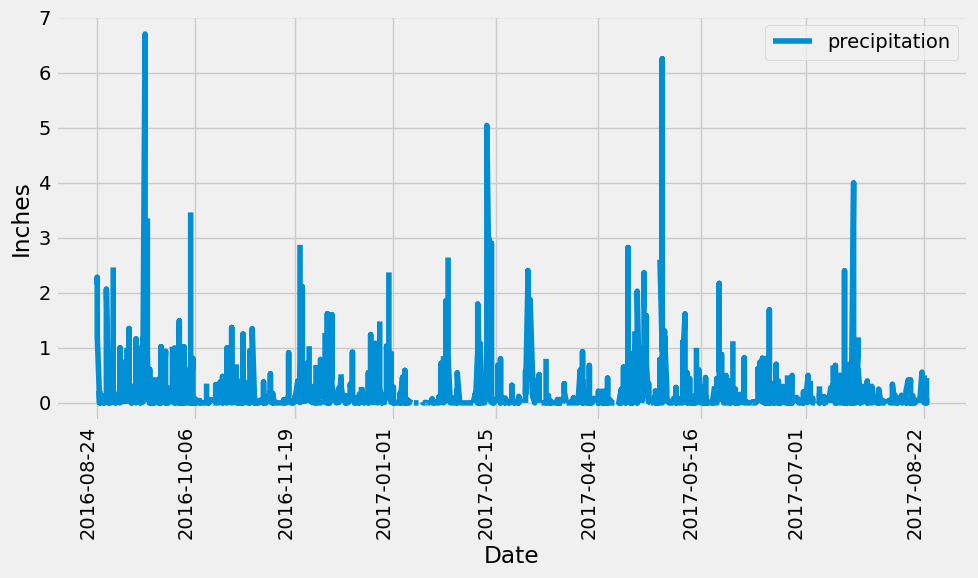

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0], "%Y-%m-%d") - dt.timedelta(days=365)
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > one_year_ago).all()
prcp

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp, columns=['date','precipitation'])

# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
prcp_df.set_index('date', inplace=True)
prcp_df.plot(x='date', y='precipitation', figsize= (10,6), legend=True)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(ticks=prcp_df.index[::len(prcp_df)//8], rotation=90)
plt.tight_layout()

In [47]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data = pd.read_csv('../Resources/hawaii_measurements.csv')
precipitation_data['prcp'].describe()

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Measurement.station).count()
num_stations

19550

In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperature_statistics = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281').all()
temperature_statistics

[(54.0, 85.0, 71.66378066378067)]

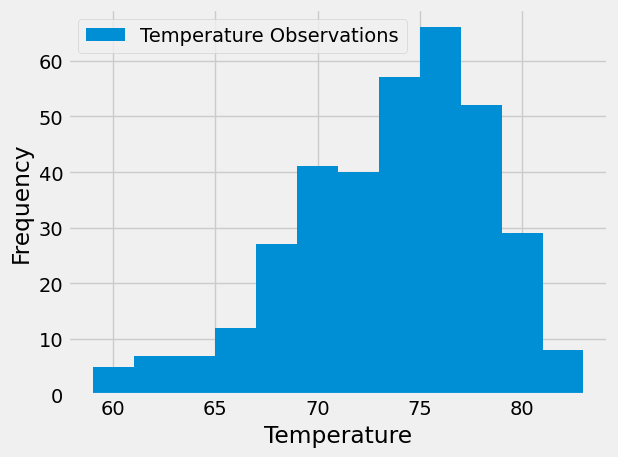

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date_dt = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date_dt - dt.timedelta(days=365)

temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == 'USC00519281',
    Measurement.date >= one_year_ago
).all()

temperature_values = [temp[0] for temp in temperature_data]

plt.hist(temperature_values, bins=12, label="Temperature Observations")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# Close Session

In [16]:
# Close Session
session.close()